/Applications/miniconda3/envs/scrna/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/Applications/miniconda3/envs/scrna/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Total number of genes: 28692
Number of genes after cell filter: 16675


... storing 'feature_types' as categorical
... storing 'genome' as categorical


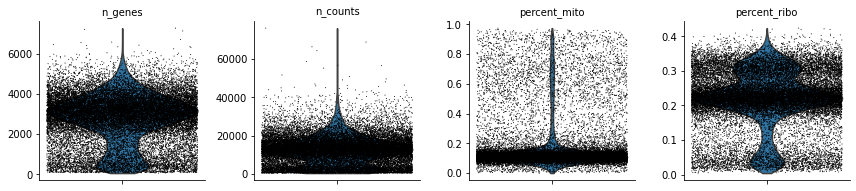

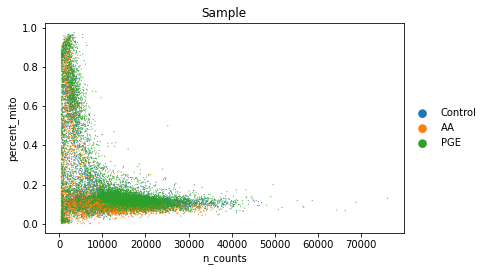

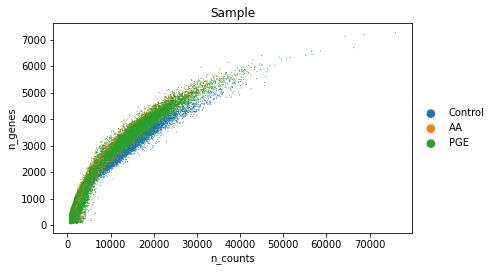

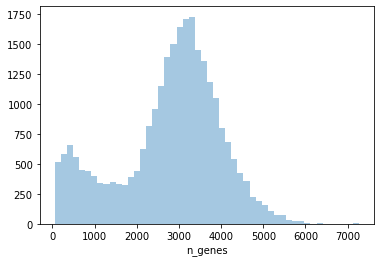

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri
import h5py
import collections
import scipy.sparse as sp_sparse
import tables

#Load in the data

adataa = sc.read_10x_h5('/Users/Vyom/data/AAPge.h5', genome=None, gex_only=True)
adataa.var_names_make_unique()

adatac = sc.read_10x_h5("/Users/Vyom/data/Controlpge.h5", genome=None, gex_only=True)
adatac.var_names_make_unique()

adatap = sc.read_10x_h5("/Users/Vyom/data/PGE.h5", genome=None, gex_only=True)
adatap.var_names_make_unique()

# merge datasets
adata1 = adatac.concatenate(adataa, adatap, batch_key='Sample', batch_categories=['Control','AA', 'PGE'])

#Filter genes that are not expressed in many cells(threshold min: 5):
print('Total number of genes: {:d}'.format(adata1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata1, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata1.n_vars))

# Calculate normalized values for counts 
adata1.obs['n_counts'] = adata1.X.sum(1)
adata1.obs['log_counts'] = np.log(adata1.obs['n_counts'])
adata1.obs['n_genes'] = (adata1.X > 0).sum(1)

#Identify number genes and counts and conduct log transformation of the counts

# filter cells that have produced less than 200 counts
sc.pp.filter_cells(adata1, min_counts=200)
# filter genes expressed in less than 3 cells
sc.pp.filter_genes(adata1, min_cells=3)

### Define gene sets for QC metrics

#Cell stress increases variability and introduces bias. As a result, it is necessary to account for cells that are high in stress as their trancriptome would vary significanly from the viable sample thus skewing results. The proportion of mitochrondrial and ribosomal counts are metrics for cell stress. Cells with an elevated proportion of mitochrondrial and ribosomal counts are exempt from the sample.

# define mitochondrial and ribosomal genes
mito_genes = [name for name in adata1.var_names if name.startswith('mt-')]
Rpl_genes = [name for name in adata1.var_names if name.startswith('Rpl')]
Rps_genes = [name for name in adata1.var_names if name.startswith('Rps')]
ribo_genes = Rpl_genes + Rps_genes
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
adata1.obs['percent_mito'] = np.sum(
    adata1[:, mito_genes].X, axis=1) / np.sum(adata1.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata1.obs['n_counts'] = np.sum(adata1.X, axis=1)
#Count IEG genes and calculate percentage per cell
#adata.obs['percent_IEG'] = np.sum(
#    adata[:, IEG].X, axis=1) / np.sum(adata.X, axis=1)
#Calculate the percent Rpl genes per cell
adata1.obs['percent_Rpl'] = np.sum(
    adata1[:, Rpl_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent Ribo genes per cell
adata1.obs['percent_ribo'] = np.sum(
    adata1[:, ribo_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent cell cycle genes per cell
#adata.obs['percent_cell_cycle'] = np.sum(
#    adata[:, cell_cycle].X, axis=1) / np.sum(adata.X, axis=1)
#sc.tl.score_genes(adata,cell_cycle,score_name='cell_cycle')


# add the total counts per cell as observations-annotation to adata

# identify proportions of stressed cells
axs = sc.pl.violin(adata1, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
                   jitter=0.4, multi_panel=True , save = 'Threshold_v.png')
ax = sc.pl.scatter(adata1, x='n_counts', y='percent_mito', color='Sample', save = 'scat_mito.png')
ax1 = sc.pl.scatter(adata1, x='n_counts', y='n_genes', color='Sample', save = 'scat_n_genes.png')
#Thresholding decision: counts
p3 = sb.distplot(adata1.obs['n_genes'], kde=False)
plt.savefig("n_genes_dist.png")


In [ ]:
#to write the output: adata1.write_loom('SB05_filtered.loom')
#to load in the said output: sc.read_loom('file_path_here')